In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 7.5]

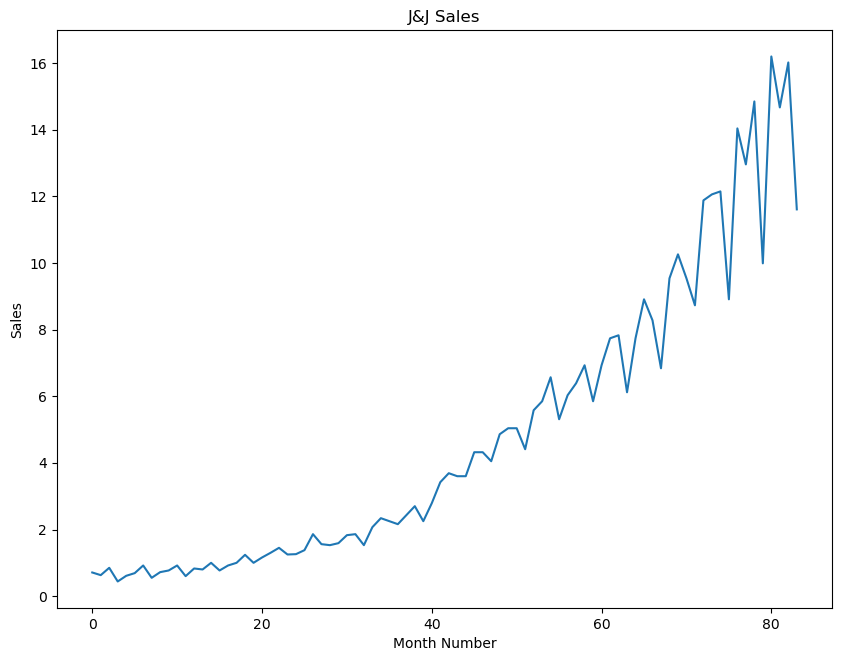

In [2]:
data = pd.read_csv('D:\Data Science\Advanced Research\Lec 3\Tutorial 3\jj.csv')
data.head()

plt.figure()
plt.plot(data['data'])
plt.title("J&J Sales")
plt.xlabel("Month Number")
plt.ylabel("Sales")

plt.show()

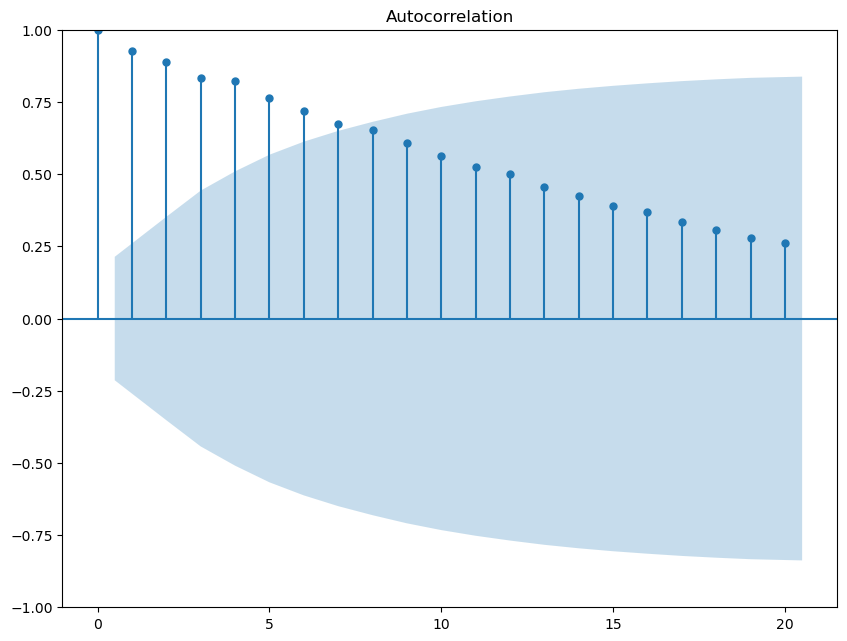

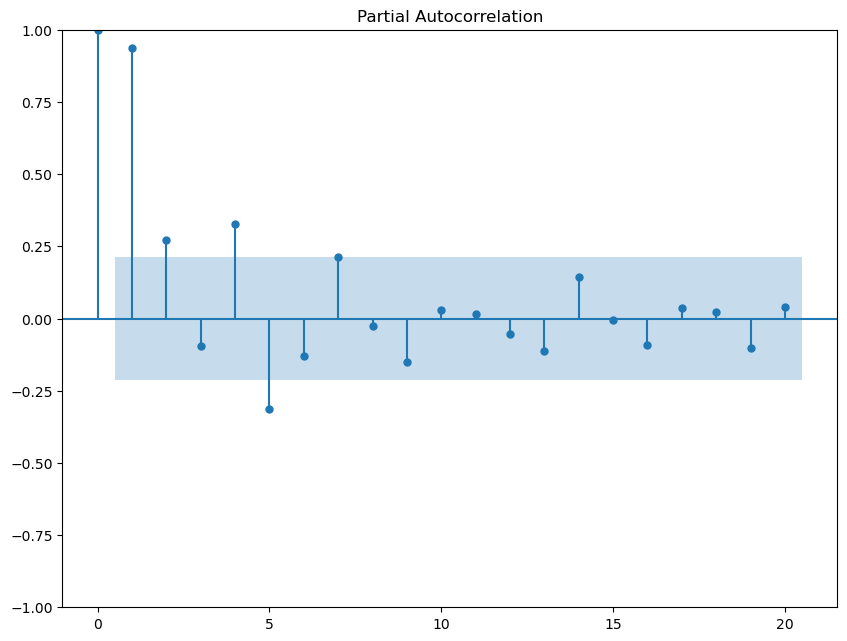

In [3]:
plot_acf(data['data'])
plot_pacf(data['data'])
plt.show()

In [4]:
adfuller_result = adfuller(data['data'])

print(f'Score = {adfuller_result[0]}')
print(f'P-value = {adfuller_result[1]}')

Score = 2.742016573457481
P-value = 1.0


In [5]:
data['Log-Transformed'] = np.log(data['data'])
data['Data-Transformed'] = data['Log-Transformed'].diff()
data.head()

,date,data,Log-Transformed,Data-Transformed
0,1960-01-01,0.71,-0.342490,NaN
1,1960-04-01,0.63,-0.462035,-0.119545
2,1960-07-02,0.85,-0.162519,0.299517
3,1960-10-01,0.44,-0.820981,-0.658462
4,1961-01-01,0.61,-0.494296,0.326684


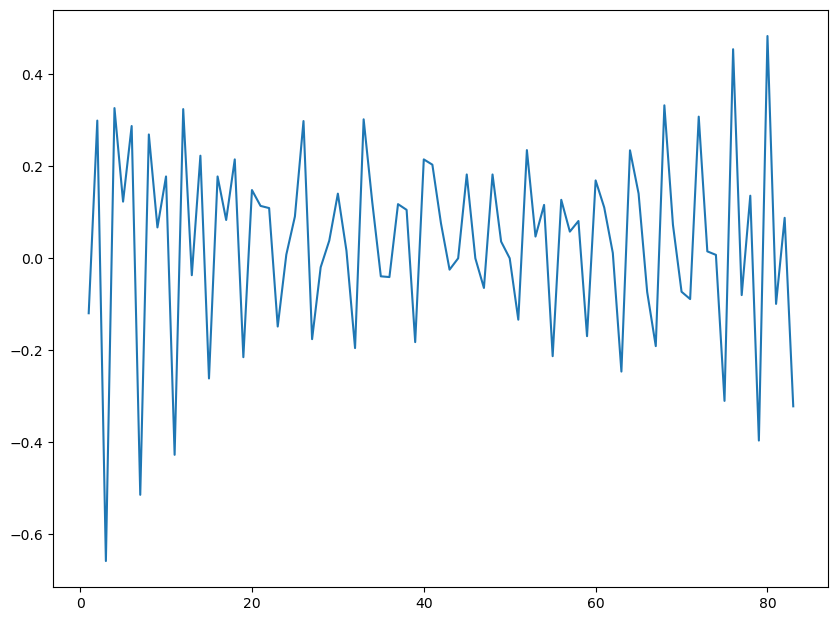

In [6]:
plt.figure()

plt.plot(data['Data-Transformed'])
plt.show()

In [7]:
adfuller_transformed_result = adfuller(data['Data-Transformed'][1:])

print(f'Statistic:{adfuller_transformed_result[0]}')
print(f'P-value:{adfuller_transformed_result[1]}')

Statistic:-4.317043945811828
P-value:0.0004149731404440809


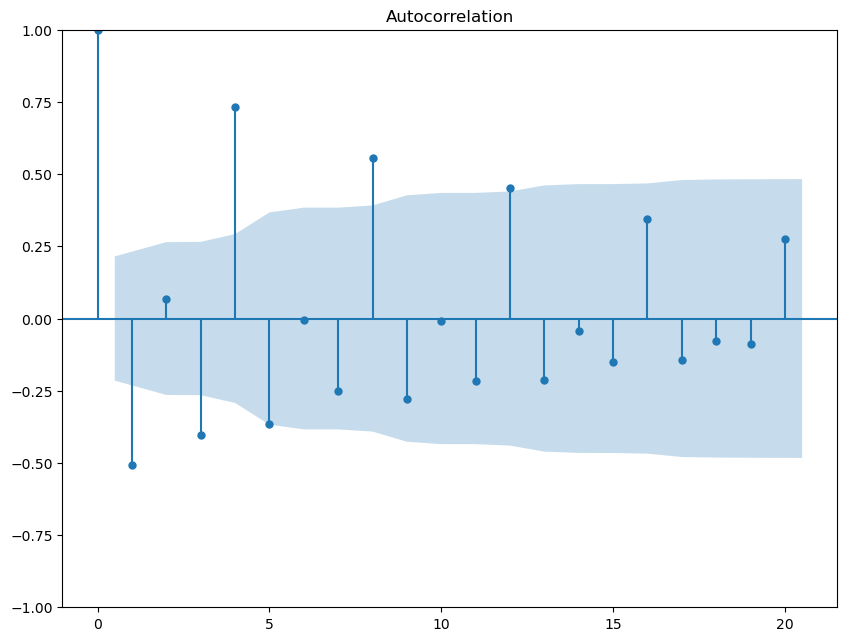

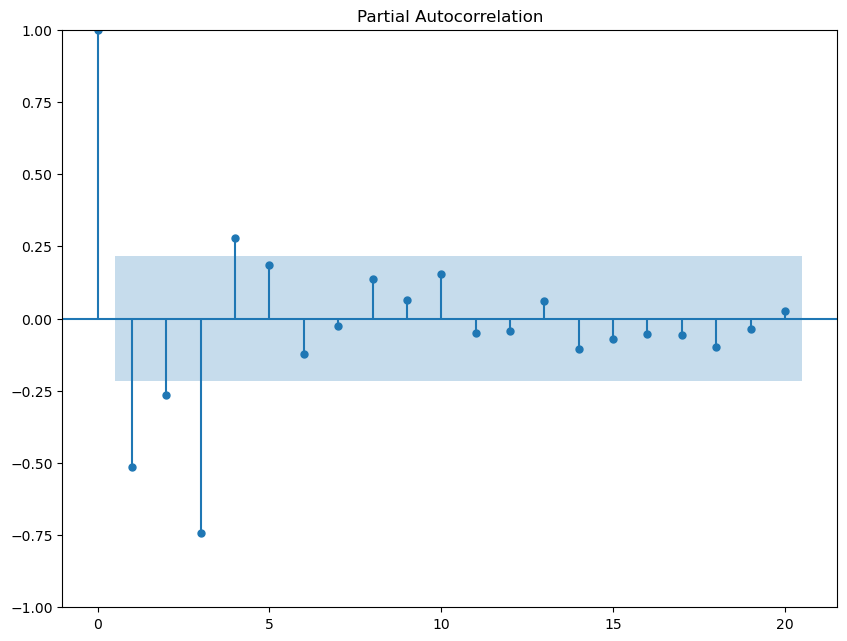

In [8]:
plot_acf(data['Data-Transformed'][1:])
plot_pacf(data['Data-Transformed'][1:])
plt.show()

In [9]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data['data'], order=(3,1,3))

model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 -76.286
Date:                Fri, 15 Dec 2023   AIC                            166.572
Time:                        18:04:46   BIC                            183.504
Sample:                             0   HQIC                           173.374
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0311      0.036    -28.923      0.000      -1.101      -0.961
ar.L2         -1.0273      0.043    -23.891      0.000      -1.112      -0.943
ar.L3         -0.9768      0.030    -32.192      0.0

In [10]:
# I have used tqdm_notebook here to add a progress bar when the script is running

def optimize_ARIMA(endog, order_list):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        endog - the observed variable, in this case data['data']
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            #model = SARIMAX(endog, order=order, simple_differencing=False).fit(disp=False)
            model = ARIMA(endog, order=order)
            model_fit = model.fit()
        except:
            continue
            
        aic = model_fit.aic
        results.append([order, model_fit.aic])
        #print(order)
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [11]:
results = []

for p in range(0,8):
    for q in range(0,8):
        model = ARIMA(data['data'], order = (p,1,q))
        model_fit = model.fit()
        
        aic = model_fit.aic
        
        results.append(((p,1,q), model_fit.aic))
        
result_df = pd.DataFrame(results, columns=['(p,1,q)', 'AIC'])
result_df = result_df.sort_values(by='AIC', ascending = True).reset_index(drop=True)    
print(result_df)

      (p,1,q)         AIC
0   (4, 1, 6)  115.859280
1   (6, 1, 3)  115.995485
2   (7, 1, 1)  116.076735
3   (5, 1, 3)  116.534546
4   (5, 1, 4)  117.244189
..        ...         ...
59  (0, 1, 1)  265.481216
60  (0, 1, 3)  265.497398
61  (1, 1, 0)  266.632563
62  (2, 1, 0)  267.751437
63  (0, 1, 0)  295.995493

[64 rows x 2 columns]


In [12]:
from statsmodels.tsa.arima.model import ARIMA

# p,d,q ARIMA Model
best_model = ARIMA(data['data'], order=(4,1,6))

best_model_fit = best_model.fit()
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(4, 1, 6)   Log Likelihood                 -46.930
Date:                Fri, 15 Dec 2023   AIC                            115.859
Time:                        18:05:18   BIC                            142.467
Sample:                             0   HQIC                           126.549
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0052      0.086     -0.061      0.952      -0.173       0.163
ar.L2         -0.0364      0.068     -0.539      0.590      -0.169       0.096
ar.L3          0.0221      0.055      0.402      0.6

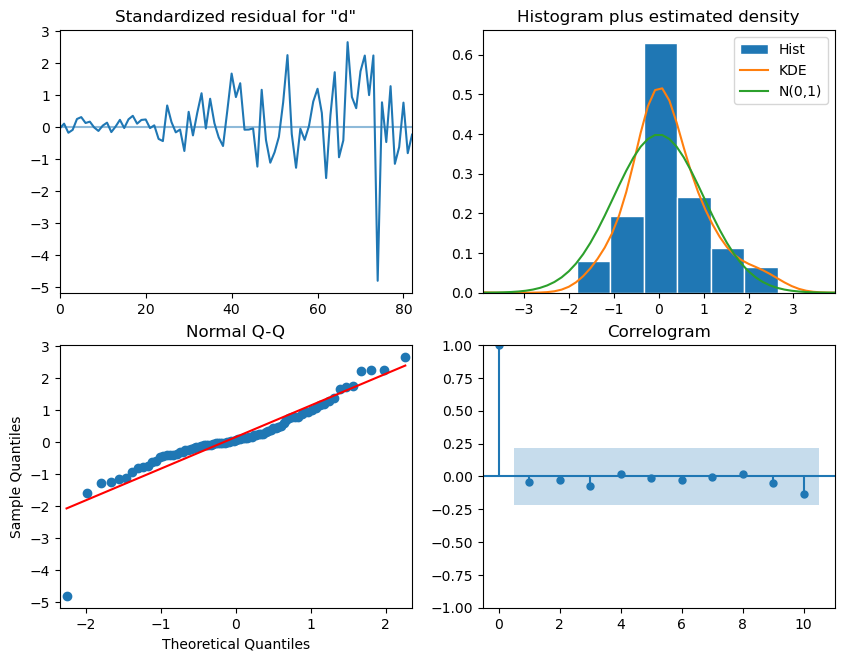

In [13]:
best_model_fit.plot_diagnostics()
plt.show()

In [14]:
test_data = data['data']

pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

predictions = best_model_fit.predict(start = pred_start_date, end = pred_end_date)
residulas = test_data - predictions


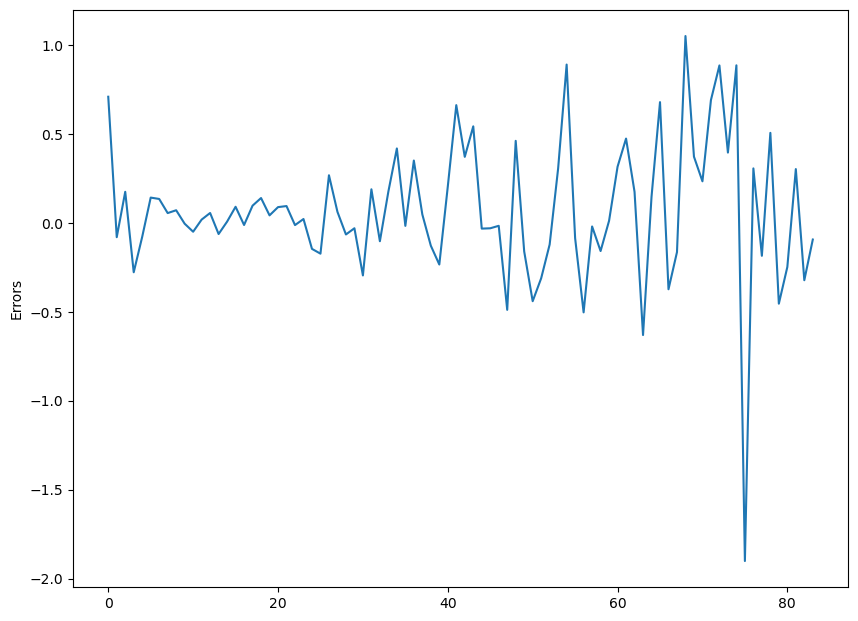

In [15]:
plt.figure()
plt.plot(residulas)
plt.ylabel('Errors')
plt.show()

In [16]:
print(f'Root Mean Squared Error:', np.sqrt(np.mean(residulas**2)))

Root Mean Squared Error: 0.4032806742237763


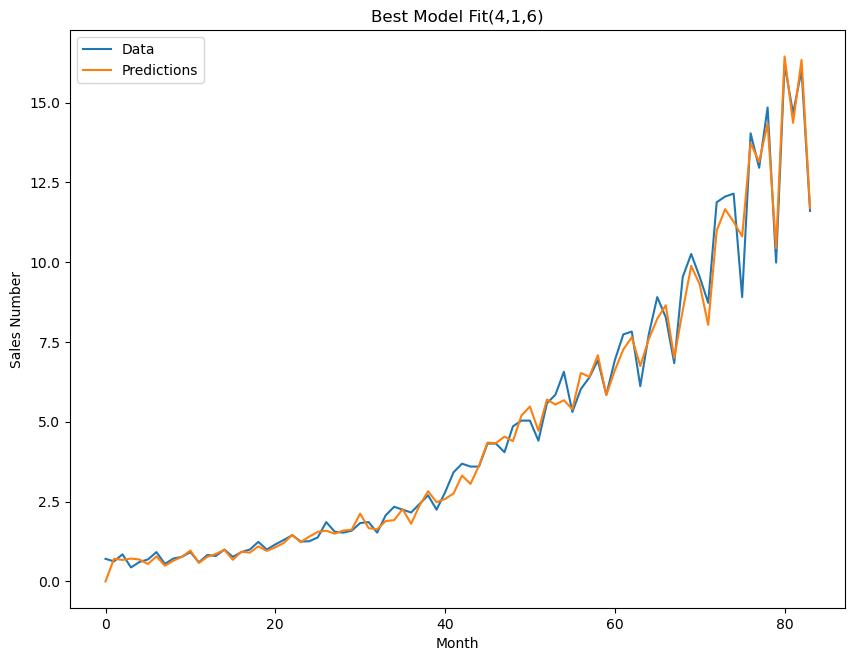

In [17]:
plt.figure()

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'))
plt.xlabel('Month')
plt.ylabel('Sales Number')
plt.title('Best Model Fit(4,1,6)')

plt.show()

In [18]:
mape = np.mean(np.abs(predictions - test_data)/np.abs(test_data))
print(f'MAPE: {mape}')

mae = np.mean(np.abs(predictions - test_data))
print(f'MAE: {mae}')

me = np.mean(predictions - test_data)
print(f'ME: {me}')

mpe = np.mean((predictions - test_data)/ test_data)
print(f'MPE: {mpe}')

rmse = np.sqrt(np.mean((predictions - test_data)**2))
print(f'RMSE: {rmse}')



MAPE: 0.08775641543468816
MAE: 0.2719807889350749
ME: -0.0696706640731884
MPE: -0.02355963735065014
RMSE: 0.4032806742237763


In [19]:
n_forecast = 24
predict = best_model_fit.get_prediction(end = model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

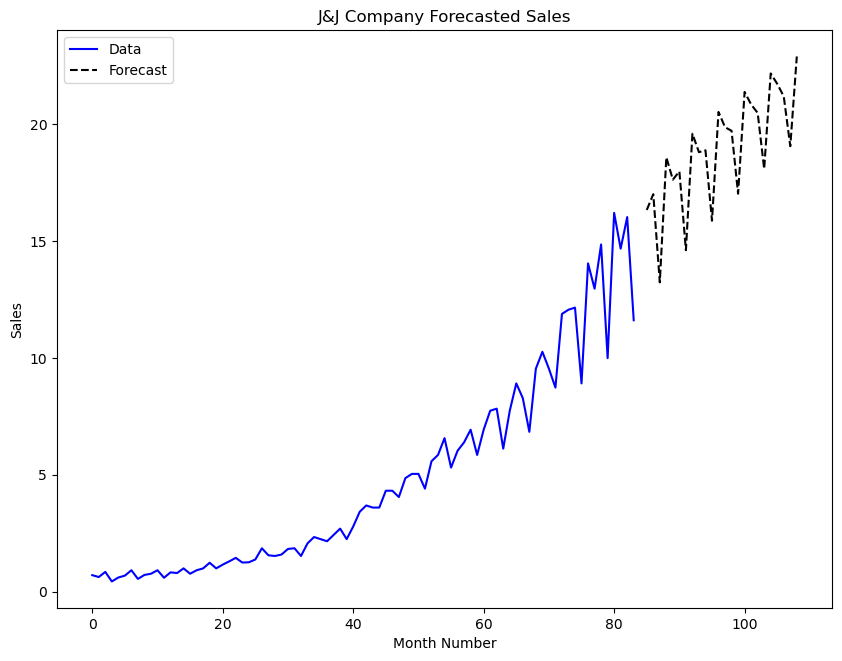

In [21]:
fig, ax= plt.subplots()
ax.plot(data['data'], 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')
plt.xlabel('Month Number')
plt.ylabel('Sales')
plt.title('J&J Company Forecasted Sales')
plt.legend(('Data', 'Forecast'))

plt.show()

In [24]:
predictions_int = best_model_fit.get_forecast(steps = 24)
predictions_int.predicted_mean

84     17.447204
85     16.325629
86     16.999885
87     13.230711
88     18.577040
89     17.619861
90     17.977186
91     14.605148
92     19.586208
93     18.796115
94     18.878388
95     15.864853
96     20.516302
97     19.864982
98     19.709345
99     17.019826
100    21.373198
101    20.836097
102    20.475487
103    18.079166
104    22.162359
105    21.718229
106    21.181850
107    19.051157
Name: predicted_mean, dtype: float64

In [25]:
predictions_int.conf_int()

,lower data,upper data
84,16.670708,18.223701
85,15.537071,17.114188
86,16.130538,17.869232
87,12.357207,14.104214
88,17.178340,19.975741
89,16.203023,19.036700
90,16.407283,19.547090
91,12.967805,16.242491
92,17.449882,21.722534
93,16.583702,21.008528


In [27]:
conf_df = pd.concat([predictions_int.predicted_mean, predictions_int.conf_int()], axis = 1)
conf_df.head()

,predicted_mean,lower data,upper data
84,17.447204,16.670708,18.223701
85,16.325629,15.537071,17.114188
86,16.999885,16.130538,17.869232
87,13.230711,12.357207,14.104214
88,18.577040,17.178340,19.975741


In [28]:
conf_df = conf_df.rename(columns = {'predicted_mean': 'Predictions', 'lower data': 'Lower CI', 'upper data': 'Upper CI'})
conf_df.head()

,Predictions,Lower CI,Upper CI
84,17.447204,16.670708,18.223701
85,16.325629,15.537071,17.114188
86,16.999885,16.130538,17.869232
87,13.230711,12.357207,14.104214
88,18.577040,17.178340,19.975741


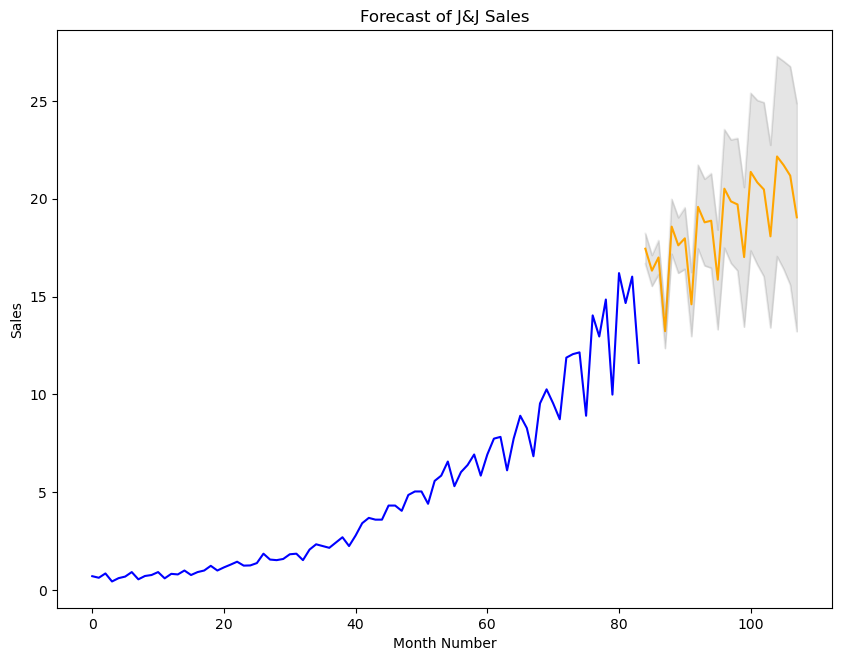

In [31]:
fig, ax = plt.subplots()
ax.plot(data['data'], 'b')

ax.set(title = 'Forecast of J&J Sales')

x = conf_df.index.values

upper = conf_df['Upper CI']
lower = conf_df['Lower CI']

conf_df['Predictions'].plot(color = 'orange', label = 'Predicted')
upper.plot(color = 'grey', label = 'Upper CI', alpha = 0.1)
lower.plot(color = 'grey', label = 'Lower CI', alpha = 0.1)

ax.fill_between(x, lower, upper, color = 'grey', alpha = 0.2)

plt.xlabel('Month Number')
plt.ylabel('Sales')

plt.show()